In [1]:
include("load_data_dependencies.jl")

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    14-element Vector{Float64}:
│     0.0
│     0.022959230401096927
│     0.04405845113136857
│     0.07084030195235157
│     0.11232953691495227
│     ⋮
│     0.754237672954132
│     0.9555284363399403
│     0.9989955251533423
│     1.0000000000000002
│     1.0000000000000002
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    15-element Vector{Float64}:
│     0.0
│     0.01947902682360647
│     0.0347242344133679
│     0.052785424819226066
│     0.09628136901295029
│     ⋮
│     0.7636614965974512
│     0.9723872952746974
│     0.999460162748707
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/y4lLj/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were 

In [343]:
using MCLLH
using DSP

In [3]:
# Cut all neutrinos outside our energy smearing energy bounds

ecut = energy_cut(rs0, ls0, bs0, rws0, us0, oneweights0, umin=log10(5e-1), umax=log10(4e3))
rs, ls, bs, rws, us, oneweights = ecut[:,1], ecut[:,2], ecut[:,3], ecut[:,4], ecut[:,5], ecut[:,6]

# rcut = r_cut(rs1, ls1, bs1, rws1, us1, oneweights1, rmin=0.3)
# rs, ls, bs, rws, us, oneweights = rcut[:,1], rcut[:,2], rcut[:,3], rcut[:,4], rcut[:,5], rcut[:,6]

# Smear the log energy Monte Carlo
us_sm = smearuMC(us, esmearvec)

# Smear in angle
ls_sm, bs_sm = angsmearMC(ls, bs);

In [257]:
r_weights = Weights(rws ./ (rs .^ 2))

rbs, lbs, bbs = 0:0.1:20, -π:π/25:π, -π/2:π/25:π/2

rlbs = Distributions.fit(Histogram, (rs, ls, bs), r_weights, (rbs, lbs, bbs)).weights

rlbs_unw = Distributions.fit(Histogram, (rs, ls, bs), (rbs, lbs, bbs)).weights;

In [456]:
sum(rlbs, dims=1)[1, :, :]

49×24 Matrix{Int64}:
 0  0   1   7   0   2  24  17  40  52  …   49  10  22   3   0  2   5   0  0
 0  1   2   2   0  11  15  23  45  29      45  13   8   8   8  6   0   5  3
 0  6   2   3   6  11  13  22  36  63      22  13   6  13   0  3   5   4  6
 1  0   1   6   5   4  12  11  24  48      21  21  25  16   5  5  10   0  3
 2  5   3  11   8   2  11  15  30  95      19  16   8  10  11  0   3   2  4
 0  4   2   0   4   6  15  16  31  55  …   33   9  19   5  12  3   0   3  5
 0  2   5   6   1  11  10   4  12  46      22  19  14  11   5  6   0   0  2
 0  3  12   3   7   1  22  16  18  11      12  30  10   4   2  6   3   8  8
 0  0   1   0   6  14  14  24   9  48      18  10   8   6   5  3   1   4  2
 0  9   6   8   6   0   6  11  29  41      17   9   4  19   7  5   5   0  6
 0  3   0   8  11   3   2  15  21  29  …   24  27  10  10  10  5   0   4  0
 0  5   0   6   7   7   3  17  25  51      44  30  21  17   7  2   6   5  3
 0  0   0   0   5   3  19  14  38  65      24  11  20   6  14  6  2

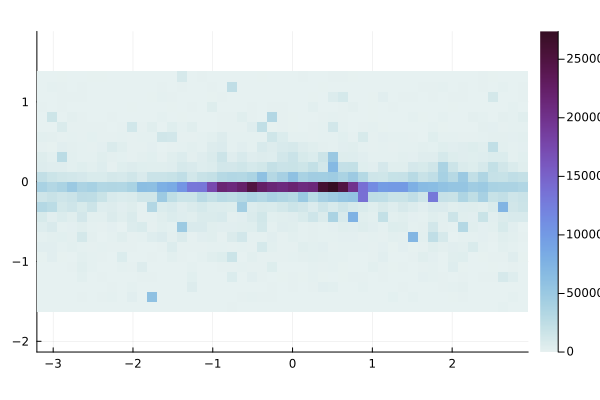

In [462]:
heatmap(
    lbs[1:end-1],
    bbs[1:end-1],
    transpose(sum(rlbs, dims=1)[1, :, :]),
    aspect_ratio=1,
    # clims=(0, maximum(rlbs)),
    c=:dense
)

In [292]:
pairs = [(rs[i], ls[i], bs[i], us[i], us_sm[i], (rws[i] / rs[i]^2)) for i in 1:length(rs) if rs[i] < 1 && lbs[20] < ls[i] < lbs[21] && bbs[23] < bs[i] < bbs[24]];

In [293]:
rndpairs = zeros(5, 6)

for i in 1:5
    for j in 1:6
        rndpairs[i, j] = round(pairs[i][j]; digits=3)
    end
end

npairs = zeros(5, 6)

for i in 1:5
    for j in 1:6
        npairs[i, j] = pairs[i][j]
    end
end

rs_s, ls_s, bs_s, us_s, us_sm_s, rws_s = npairs[:,1], npairs[:,2], npairs[:,3], npairs[:,4], npairs[:,5], npairs[:,6];

In [308]:
old_ws_s = Weights(ones(length(rs_s)))

ews_s = Weights(old_ws_s .* power_law_flux.(10 .^ us_s, 2.4-1))

aws_s = effarea.(10 .^ us_s) * 10000

oscws_null_s = oscprob.(10 .^ us_s, 0, rs_s)

dm2 = 10^(-10)
dm2 = ones(length(rs_s)) .* dm2
oscws_s = oscprob.(10 .^ us_s, dm2, rs_s);

In [326]:
rs_s

5-element Vector{Float64}:
 0.0808569151672878
 0.0808569151672878
 0.08447198764845056
 0.5393625575371355
 0.5393625575371355

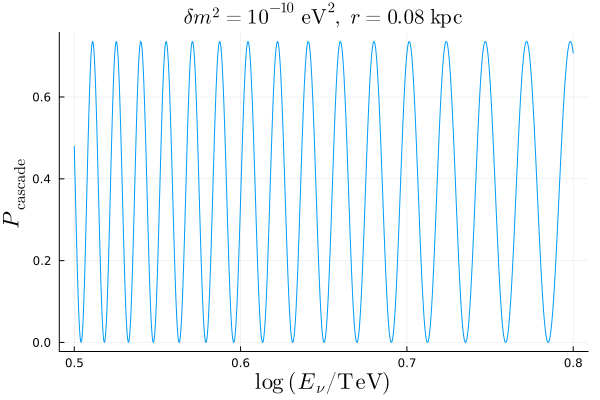

In [442]:
sample = range(0.5, 0.8, 1000)
plot(
    sample,
    oscprob.(10 .^ sample, 10^(-10), 0.0808),
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15,
    title=L"\delta m^2 = 10^{-10}~\mathrm{eV^2},~r = 0.08~\mathrm{kpc}",
    ylabel=L"P_\mathrm{cascade}",
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    label=false
)
#=
plot!(
    sample,
    [us_s[1]],
    seriestype=:vline,
    lw=2,
    label=L"P_\mathrm{cascade} = 0.016"
)
plot!(
    sample,
    [us_s[2]],
    seriestype=:vline,
    lw=2,
    label=L"P_\mathrm{cascade} = 0.62"
)
plot!(
    sample,
    [us_s[3]],
    seriestype=:vline,
    lw=2,
    label=L"P_\mathrm{cascade} = 0.0001"
)
plot!(
    sample,
    [us_s[4]],
    seriestype=:vline,
    lw=1.5,
)
plot!(
    sample,
    [us_s[5]],
    seriestype=:vline,
    lw=1.5,
)
=#

In [449]:
owvec = oscprob.(10 .^ sample, 10^(-9.5), 0.0808)

d = Normal(0.65, 0.001)

gaussvec(x) = pdf(d, x)

gvec = gaussvec.(sample);

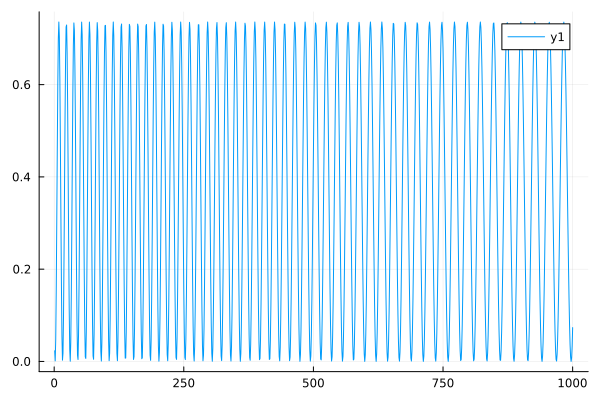

In [450]:
plot(
    [owvec]
)

In [451]:
cvec = conv(gvec, owvec);

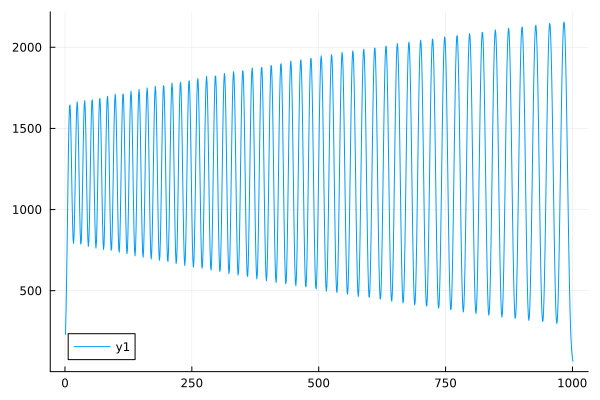

In [452]:
plot(
    cvec[500:1500]
)

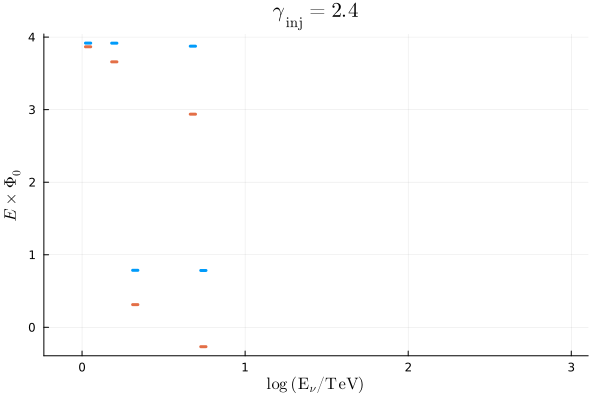

In [312]:
us_b = Distributions.fit(Histogram, us_s, Weights(rws_s), range(log10(emin), log10(emax), 100))
us_bw = Distributions.fit(Histogram, us_s, Weights(rws_s .* ews_s), range(log10(emin), log10(emax), 100))
plot(
    range(log10(emin), log10(emax), 100)[1:end-1], 
    [log10.(us_b.weights) log10.(us_bw.weights)], 
    seriestype=:step,
    label=false,
    # label=[L"r\mathrm{~weighted~flux}" L"r+\mathrm{energy~weighted~flux}"],
    ylabel=L"E\times\Phi_0",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    title=L"\gamma_\mathrm{inj} = 2.4",
    lw=3,
    # legendfontsize=12
)

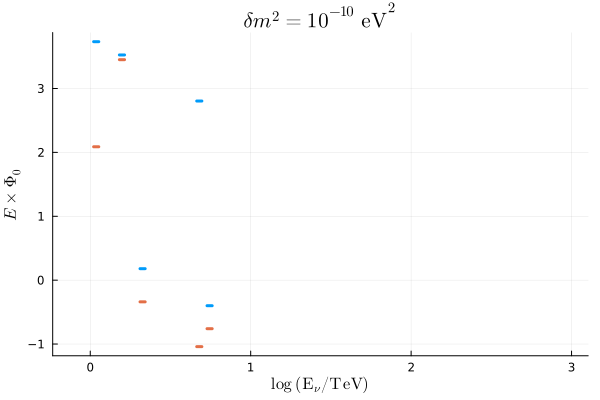

In [313]:
binned_new_us = Distributions.fit(Histogram, us_s, Weights(rws_s .* ews_s .* oscws_null_s), range(log10(emin), log10(emax), 100))
binned_nnew_us = Distributions.fit(Histogram, us_s, Weights(rws_s .* ews_s .* oscws_s), range(log10(emin), log10(emax), 100))
plot(
    range(log10(emin), log10(emax), 100)[1:end-1], 
    [log10.(binned_new_us.weights) log10.(binned_nnew_us.weights)], 
    seriestype=:step,
    # label=[L"\mathrm{null}" L"\mathrm{alt}"],
    label=false,
    ylabel=L"E \times \Phi_0",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    title=L"\delta m^2 = 10^{-10}~\mathrm{eV}^2",
    lw=3,
    legendfontsize=12
)

In [300]:
basews_s = base_weights(2.4, rs_s, rws_s, us_s)
nullbedists_s = binnededists(0; rs=rs_s, ls=ls_s, bs=bs_s, us=us_s, us_sm=us_sm_s, bws=basews_s, ϕ₀=1, r_min=0, sq_errs=true)[1]
bedists_s = binnededists(10^(-10); rs=rs_s, ls=ls_s, bs=bs_s, us=us_s, us_sm=us_sm_s, bws=basews_s, ϕ₀=1, r_min=0, sq_errs=true)[1];

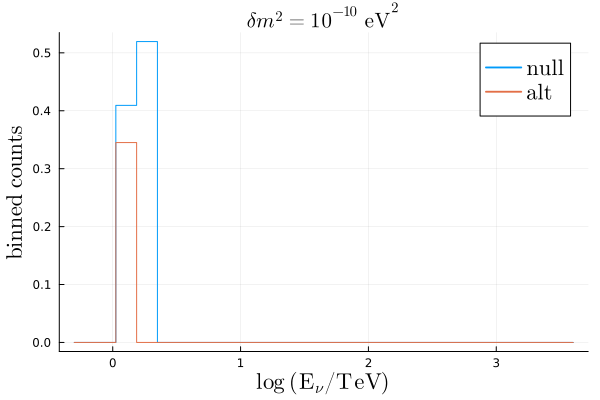

In [342]:
plot(
    loges25,
    [0.01*nullbedists_s[20, 23, :] 0.01*bedists_s[20, 23, :]],
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    ylabel=L"\mathrm{binned~counts}",  
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    title=L"\delta m^2 = 10^{-10}~\mathrm{eV}^2",
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15
)

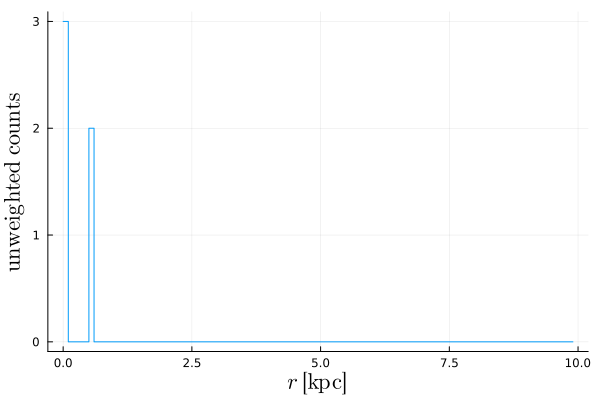

In [273]:
plot(
    rbs[1:100],
    rlbs_unw[:, 20, 23][1:100],
    seriestype=:step,
    label=false,
    xlabel=L"r~\mathrm{[kpc]}",
    ylabel=L"\mathrm{unweighted~counts}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
)

In [151]:
function weights_errs(binned_var, weights_vec, edges; sqerrs=true)

    binned = Distributions.fit(Histogram, binned_var, Weights(weights_vec), edges).weights
    b_err = Distributions.fit(Histogram, binned_var, Weights(weights_vec .^ 2), edges).weights
    errs = sqrt.(b_err)
    if sqerrs
        return binned, errs
    else
        return binned, b_err
    end
end

weights_errs (generic function with 1 method)

In [181]:
function weighthist_es(ls, bs, us, us_sm, weights; smear=false, sqerr=true, θbinsize=π/25, minloge=log10(emin), maxloge=log10(emax), elength=26)

    # We take square angular bins
    lbins, bbins, logebins = -π:θbinsize:π, -π/2:θbinsize:π/2, range(minloge, maxloge, length=elength)

    ϕ₀ = 3.287790846405607e-8

    if smear
        binnedu = us_sm
    else
        binnedu = us
    end

    nuws, nuerrs = weights_errs((ls, bs, binnedu), ϕ₀*weights, (lbins, bbins, logebins); sqerrs=sqerr)
    #=
    nuhist = StatsBase.fit(Histogram, (ls, bs, us), weights, (lbins, bbins, logebins), closed=:left)
    nuws = Φ₀ * nuhist.weights

    err = StatsBase.fit(Histogram, (ls, bs, us), Weights(weights .^ 2), (lbins, bbins, logebins), closed=:left)
    errws = Φ₀ * sqrt.(err.weights)
    =#

    return nuws, nuerrs

end

weighthist_es (generic function with 2 methods)

In [188]:
function base_weights(γ_inj, rs, rws, us)

    old_ws = Weights(ones(length(rs)))
    r_weights = Weights(rws ./ (rs .^ 2))
    ews = Weights(old_ws .* power_law_flux.(10 .^ us, γ_inj - 1))
    aws = effarea.(10 .^ us) * 10000

    return r_weights .* ews .* aws

end

basews = base_weights(2.4, rs, rws, us)

# oscws_null = oscprob.(10 .^ us, 0, rs)

# nullws = basews .* oscws_null

# nullws_sm, nullerrs_sm = weighthist_es(ls_sm, bs_sm, us, us_sm, nullws, smear=true)

function binnededists(δm²; rs=rs, ls=ls, bs=bs, us=us, us_sm=us_sm, bws=basews, ϕ₀=1, r_min=0, sq_errs=true, convu=true)

    if r_min > 0
        rcut = r_cut(rs, ls, bs, bws, us, us_sm, rmin=r_min)
        rs, ls, bs, bws, us, us_sm = rcut[:,1], rcut[:,2], rcut[:,3], rcut[:,4], rcut[:,5], rcut[:,6]
    end

    oscws_alt = oscprob.(10 .^ us, δm², rs)

    if convu

        


    ws = ϕ₀ .* bws .* oscws_alt

    nullws, nullerrs = weighthist_es(ls, bs, us, us_sm, ws; smear=true, sqerr=sq_errs)

    return nullws, nullerrs

end

binnededists (generic function with 1 method)

In [183]:
nullws, nullerrs = binnededists(0, r_min=0.1)
altws, alterrs = binnededists(10^(-14), r_min=0.1);

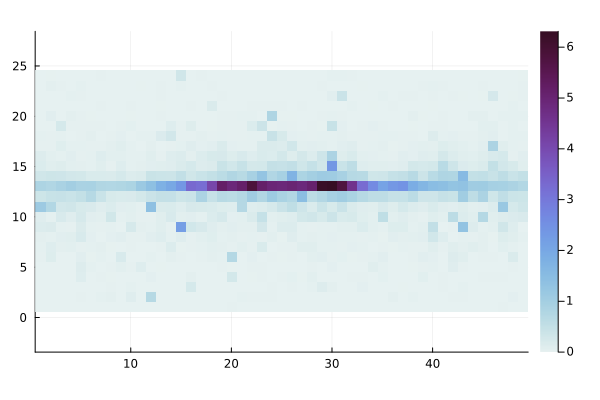

In [461]:
nullsums = sum(nullws, dims=3)[:, :, 1]

heatmap(transpose(nullsums), aspect_ratio=1, c=:dense)

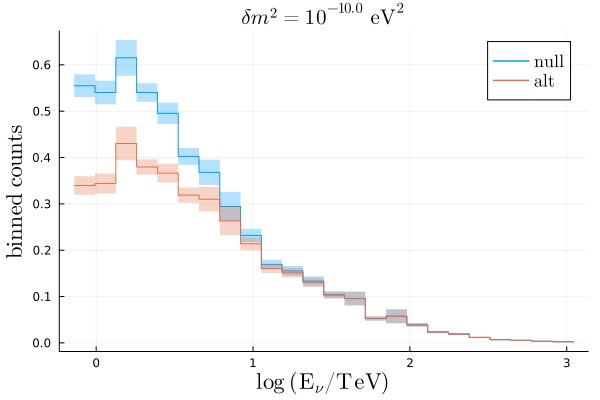

In [184]:
l = 25
b = 13

nullbin = nullws[l, b, :]
nullerrbin = nullerrs[l, b, :]

altbin = altws[l, b, :]
alterrbin = alterrs[l, b, :]
;

plot(
    range(log10(emin), log10(emax), 25),
    [nullbin altbin], 
    ribbon=[nullerrbin alterrbin],
    fillalpha=0.3,
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    ylabel=L"\mathrm{binned~counts}",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    # title=L"\delta m^2 = 10^{-13.8}~\mathrm{eV}^2,~7^\circ~\mathrm{degree~bin}"
    title=L"\delta m^2 = 10^{-10.0}~\mathrm{eV^2}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
)

In [189]:
function param_optimizer(δm²; rs=rs, ls=ls, bs=bs, us=us, us_sm=us_sm, bws=basews, r_min=0)

    if r_min > 0
        rcut = r_cut(rs, ls, bs, bws, us, us_sm, rmin=r_min)
        rs, ls, bs, bws, us, us_sm = rcut[:,1], rcut[:,2], rcut[:,3], rcut[:,4], rcut[:,5], rcut[:,6]
    end

    nulldists = binnededists(0)[1]

    function negloglh(δm², norm, nulldists)
        altdistws, altdistwssq = binnededists(δm²; ϕ₀=norm, sq_errs=false)

        sumllh = 0

        for i in 1:24
            for j in 1:49
                altsummand = LLHeff.(nulldists[j, i, :], altdistws[j, i, :], altdistwssq[j, i, :])
                sumllh += -sum(altsummand)
            end
        end
        return sumllh
    end

    function maxloglh_params(δm²)

        function nllh(test)
            return negloglh(δm², test[1], nulldists)
        end
    
        x0 = [1.0]
    
        optimized = optimize(nllh, x0, NelderMead())

        asmaxparams = Optim.minimizer(optimized)
    
    end

    return maxloglh_params(δm²)

end

function lrt_MCLLH(nullws, nullwssq, altws, altwssq)
    altsummand = sum(LLHeff.(nullws, altws, altwssq) .- LLHeff.(nullws, nullws, nullwssq))
    ts = -2 * altsummand
end

function asts(δm²; r_min=0)
    nulldistws, nulldistwssq = binnededists(0; r_min=r_min, sq_errs=false)
    maxparams = param_optimizer(δm²; r_min=r_min)
    altdistws, altdistwssq = binnededists(δm²; ϕ₀=maxparams[1], r_min=r_min, sq_errs=false)
    tscontributions = [lrt_MCLLH(nulldistws[i, j, :], nulldistwssq[i, j, :], altdistws[i, j, :], altdistwssq[i, j, :]) for j in 1:24, i in 1:49]
end;

In [318]:
testts = asts(10^(-10); r_min=0.1)

24×49 Matrix{Real}:
  0            0            0            …   0            0
  0            0            0.000342109      0.00431032   0
  0            0.000650982  0.000514865     -0.0003063    0
  0.00112697   0.000154028  2.24954e-5       0            0.0134975
  0            0            0.000937832      0.0030196    0.0119363
 -0.00485531   0.0208993    0.00608699   …   0.0170097   -0.000111709
  0.0154933   -0.0137988    0.00617269       0.0182921    0.0130313
  0.0204973   -0.00176996   0.0819289        0.064862     0.0287968
  0.104211     0.211979     0.0233672        0.0238332    0.00223704
  0.0439742    0.000597344  0.0971753       -0.0264023    0.047826
  0.482226     1.06635      0.130649     …   0.0550472    0.332359
  0.0436242    0.102939     0.0302627        0.0564407    0.0465309
  0.0876575    0.0669913    0.0643128        0.0263823    0.0929577
  0.0495491    0.0509348    0.0163051        0.0568649    0.0944323
  0.0688622    0.0134484    0.0549552        0.0776

In [319]:
optnorm = param_optimizer(10^(-10); r_min=0.1)

1-element Vector{Float64}:
 1.6122463226318358

In [321]:
allskyedists_null, allskyerrs_null = binnededists(0; r_min=0.1)
allskyedists_alt, allskyerrs_alt = binnededists(10^(-10); ϕ₀=optnorm, r_min=0.1);

In [322]:
sum(testts)

52.82657132254651

In [323]:
argmax(testts)

CartesianIndex(10, 35)

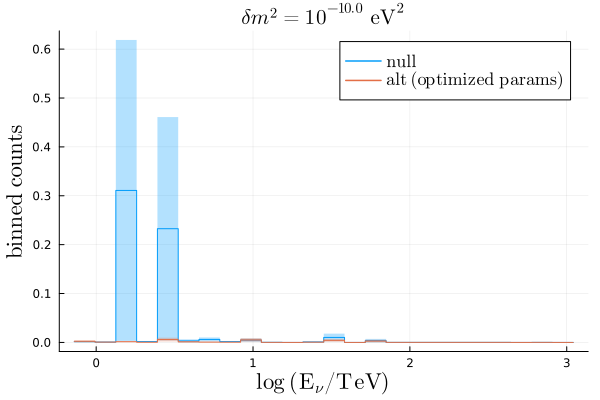

In [324]:
l, b = 35, 10

plot(
    range(log10(emin), log10(emax), 25),
    [allskyedists_null[l, b, :] allskyedists_alt[l, b, :]], 
    ribbon=[allskyerrs_null[l, b, :] allskyerrs_alt[l, b, :]],
    fillalpha=0.3,
    seriestype=:step,
    label=[L"\mathrm{null}" L"\mathrm{alt~(optimized~params)}"],
    ylabel=L"\mathrm{binned~counts}",
    xlabel=L"\mathrm{\log~(E_\nu/\mathrm{TeV})}",
    # title=L"\delta m^2 = 10^{-13.8}~\mathrm{eV}^2,~7^\circ~\mathrm{degree~bin}"
    title=L"\delta m^2 = 10^{-10.0}~\mathrm{eV^2}",
    legendfontsize=12,
    xguidefontsize=15,
    yguidefontsize=15
    )

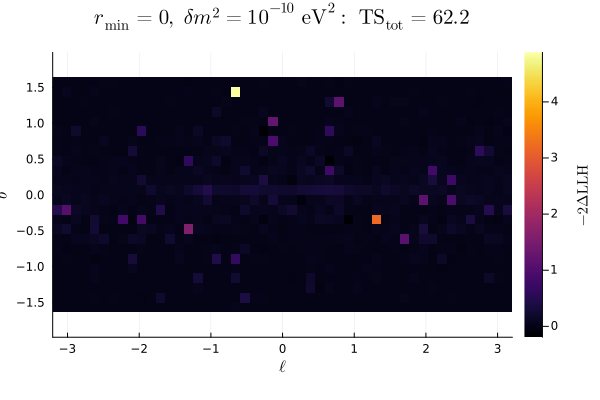

In [269]:
heatmap(
    range(-π, π, 49),
    range(-π/2, π/2, 24),
    testts, 
    aspect_ratio=1,
    xlabel=L"\ell",
    ylabel=L"b",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    title=L"r_\mathrm{min} = 0,~\delta m^2 = 10^{-10}~\mathrm{eV^2}:~\mathrm{TS_{tot} = 62.2}"
)

In [93]:
cfactor = 3.086e19 * 5.06773093741 * 1e6

leff = 0.01 #kpc
et = 1 #TeV

log10((leff * cfactor)/(4*et*1e12))

# osc = (cos((dm2 * leff)/(4*et*1e12)))^2

11.592149479092791

In [230]:
sum(asts(10^(-20); r_min=1))

4.181276266821477

In [216]:
rmins = range(0, 1, 11)
logdm2s = range(-14, -10, 11)
tss_contribs = [asts(10^(logdm2), r_min=rmin) for logdm2 in logdm2s, rmin in rmins]

11×11 Matrix{Matrix{Real}}:
 [0 0 … 0 0; 0 0 … -0.00576818 0; … ; 0 -0.0106897 … 0 -0.00257768; 0 -0.00193376 … 0 -0.00181681]    …  [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 -3.26469e-5; 0 -0.00193376 … 0 0]
 [0 0 … 0 0; 0 0 … -0.0036925 0; … ; 0 -0.00423456 … 0 -0.000916965; 0 -0.00176009 … 0 -0.000742993]     [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 -2.72946e-5; 0 -0.00176009 … 0 0]
 [0 0 … 0 0; 0 0 … -0.00685053 0; … ; 0 0.00275903 … 0 0.0015488; 0 0.00565533 … 0 0.000309967]          [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 -6.67267e-5; 0 0.00565533 … 0 0]
 [0 0 … 0 0; 0 0 … 0.105351 0; … ; 0 -0.00387728 … 0 0.00546992; 0 -0.000736641 … 0 -0.000514959]        [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 9.69576e-5; 0 -0.000736641 … 0 0]
 [0 0 … 0 0; 0 0 … -0.00604 0; … ; 0 0.267408 … 0 0.00945563; 0 0.0202616 … 0 0.00314806]                [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0.000734984; 0 0.0202616 … 0 0]
 [0 0 … 0 0; 0 0 … 0.0103715 0; … ; 0 -0.00447882 … 0 0.00202477; 0 0.000462354 … 0 0.00898758]       …  

In [217]:
tss = sum.(tss_contribs)

11×11 Matrix{Float64}:
  4.67369   6.62175  10.9089  13.6094  …  17.6106  18.1968  18.659   19.0101
 26.4093   27.1989   29.3431  31.1539     35.2981  36.0866  36.7114  37.2049
 44.7319   43.7968   43.0134  43.7753     45.2143  44.9216  44.0284  43.0545
 56.0193   52.3978   48.1214  45.2284     36.8228  34.9774  33.3152  31.8107
 62.733    57.8016   43.8224  35.3001     23.4512  21.6043  20.4197  19.2315
 68.8093   60.5047   45.9645  29.5866  …  17.9948  16.5704  15.1958  14.0194
 63.4281   48.2316   32.0795  27.5874     15.3378  13.9037  12.5951  11.486
 54.5908   51.4893   34.8551  26.9718     13.8872  12.3208  10.8908   9.92896
 59.5909   48.7194   34.2553  26.2088     15.1567  13.1601  11.8083  10.9149
 72.8122   60.2348   36.6084  26.6784     14.5357  12.6416  11.1674  10.092
 62.1807   52.8266   39.3088  26.3062  …  14.727   12.6436  11.3043  10.1519

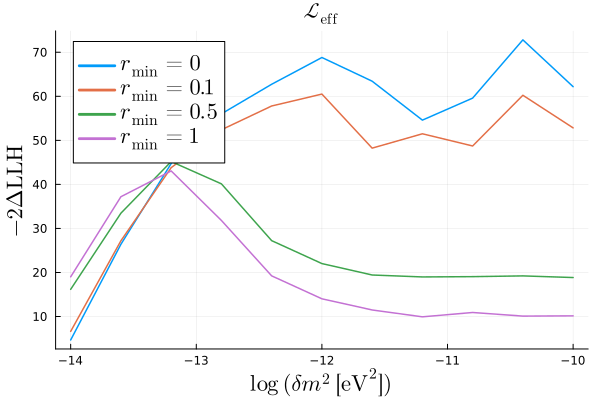

In [234]:
plot(
    range(-14, -10, 11),
    [tss[:,1] tss[:,2] tss[:,6] tss[:,11]],
    xlabel=L"\log~(\delta m^2~\mathrm{[eV^2]})",
    ylabel=L"-2\Delta\mathrm{LLH}",
    label=[L"r_\mathrm{min} = 0" L"r_\mathrm{min} = 0.1" L"r_\mathrm{min} = 0.5" L"r_\mathrm{min} = 1"],
    title=L"\mathcal{L}_\mathrm{eff}",
    lw=1.5,
    legendfontsize=15,
    xguidefontsize=15,
    yguidefontsize=15
)

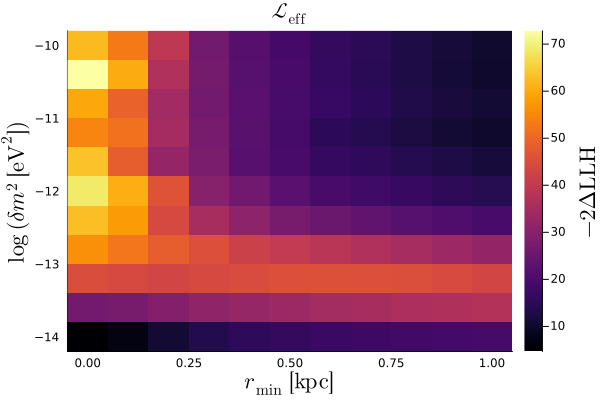

In [239]:
heatmap(
    rmins, 
    logdm2s, 
    tss,
    title=L"\mathcal{L}_\mathrm{eff}",
    xlabel=L"r_\mathrm{min}~\mathrm{[kpc]}",
    ylabel=L"\log~(\delta m^2~\mathrm{[eV^2]})",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    colorbar_titlefontsize=15,
    xguidefontsize=15,
    yguidefontsize=15
)